# Do generations exist?

This notebook contains a "one-day paper", my attempt to pose a research question, answer it, and publish the results in one work day (May 13, 2016).

Copyright 2016 Allen B. Downey

MIT License: https://opensource.org/licenses/MIT

In [1]:
from __future__ import print_function, division

from thinkstats2 import Pmf, Cdf

import thinkstats2
import thinkplot

import pandas as pd
import numpy as np
from scipy.stats import entropy

%matplotlib inline

### What's a generation supposed to be, anyway?

If generation names like "Baby Boomers" and "Generation X" are just a short way of referring to people born during certain intervals, you can use them without implying that these categories have any meaningful properties.

But if these names are supposed to refer to generations with identifiable characteristics, we can test whether these generations exist.  In this notebook, I suggest one way to formulate generations as a claim about the world, and test it.

Suppose we take a representative sample of people in the U.S., divide them into cohorts by year of birth, and measure the magnitude of the differences between consecutive cohorts.  Of course, there are many ways we could define and measure these differences; I'll suggest one in a minute.

But ignoring the details for now, what would those difference look like if generations exist?  Presumably, the differences between successive cohorts would be relatively small within each generation, and bigger between generations.

If we plot the cumulative total of these differences, we expect to see something like the figure below (left), with relatively fast transitions (big differences) between generations, and periods of slow change (small differences) within generations.

On the other hand, if there are no generations, we expect the differences between successive cohorts to be about the same.  In that case the cumulative differences should look like a straight line, as in the figure below (right):

![Diagrams showing hypothetical data.](generation_cartoon.png)

So, how should we quantify the differences between successive cohorts.  When people talk about generational differences, they are often talking about differences in attitudes about political, social issues, and other cultural questions.  Fortunately, these are exactly the sorts of things surveyed by the General Social Survey (GSS).

To gather data, I selected question from the GSS that were asked during the last three cycles (2010, 2012, 2014) and that were coded on a 5-point Likert scale.

You can see the variables that met these criteria, and download the data I used, here:

https://gssdataexplorer.norc.org/projects/13170/variables/data_cart

Now let's see what we got.

First I load the data dictionary, which contains the metadata:

In [2]:
dct = thinkstats2.ReadStataDct('GSS.dct')

Then I load the data itself:

In [3]:
df = dct.ReadFixedWidth('GSS.dat')

I'm going to drop two variables that turned out to be mostly N/A

In [4]:
df.drop(['immcrime', 'pilloky'], axis=1, inplace=True)

And then replace the special codes 8, 9, and 0 with N/A

In [5]:
df.ix[:, 3:] = df.ix[:, 3:].replace([8, 9, 0], np.nan)
df.head()

year  id_  age  wrkwayup  fepol  pillok  premarsx  spanking  fechld  \
0  2010    1   31         4      2       1         4         4       2   
1  2010    2   23         5      2       1         4         3       2   
2  2010    3   71       NaN      2       2         1         1       3   
3  2010    4   82         2      2       1         3         3       3   
4  2010    5   78       NaN    NaN     NaN       NaN       NaN     NaN   

   fepresch    ...     patriot2  patriot3  patriot4  poleff18  poleff19  \
0         2    ...          NaN       NaN       NaN       NaN       NaN   
1         3    ...          NaN       NaN       NaN       NaN       NaN   
2         2    ...          NaN       NaN       NaN       NaN       NaN   
3         2    ...          NaN       NaN       NaN       NaN       NaN   
4       NaN    ...          NaN       NaN       NaN       NaN       NaN   

   poleff20  govdook  polgreed  choices  refrndms  
0       NaN        3         2      NaN       NaN  
1       NaN        4         4      NaN       NaN  
2       NaN        3         4      NaN       NaN  
3       NaN        2         2      NaN       NaN  
4       NaN      NaN       NaN      NaN       NaN  

[5 rows x 150 columns]

For the age variable, I also have to replace 99 with N/A

In [6]:
df.age.replace([99], np.nan, inplace=True)

Here's an example of a typical variable on a 5-point Likert scale.

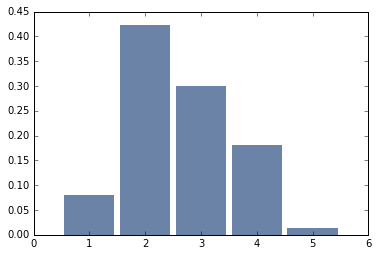

In [7]:
thinkplot.Hist(Pmf(df.choices))

I have to compute year born

In [8]:
df['yrborn'] = df.year - df.age

Here's what the distribution looks like.  The survey includes roughly equal numbers of people born each year from 1922 to 1996.

{'xscale': 'linear', 'yscale': 'linear'}

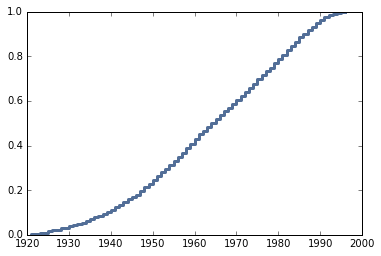

In [9]:
pmf_yrborn = Pmf(df.yrborn)
thinkplot.Cdf(pmf_yrborn.MakeCdf())

Next I sort the respondents by year born and then assign them to cohorts so there are 200 people in each cohort.

In [10]:
df_sorted = df[~df.age.isnull()].sort_values(by='yrborn')
df_sorted['counter'] = np.arange(len(df_sorted), dtype=int) // 200
df_sorted[['year', 'age', 'yrborn', 'counter']].head()

year  age  yrborn  counter
1411  2010   89    1921        0
1035  2010   89    1921        0
1739  2010   89    1921        0
1490  2010   89    1921        0
861   2010   89    1921        0

In [11]:
df_sorted[['year', 'age', 'yrborn', 'counter']].tail()

year  age  yrborn  counter
4301  2014   18    1996       32
4613  2014   18    1996       32
4993  2014   18    1996       32
4451  2014   18    1996       32
6032  2014   18    1996       32

I end up with the same number of people in each cohort (except the last).

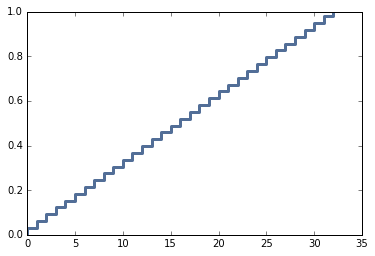

In [12]:
thinkplot.Cdf(Cdf(df_sorted.counter))
None

Then I can group by cohort.

In [13]:
groups = df_sorted.groupby('counter')

I'll instantiate an object for each cohort.

In [14]:
class Cohort:
    skip = ['year', 'id_', 'age', 'yrborn', 'cohort', 'counter']
    
    def __init__(self, name, df):
        self.name = name
        self.df = df
        self.pmf_map = {}
        
    def make_pmfs(self):
        for col in self.df.columns:
            if col in self.skip:
                continue
            self.pmf_map[col] = Pmf(self.df[col].dropna())
            try:
                self.pmf_map[col].Normalize()
            except ValueError:
                print(self.name, col)
            
    def total_divergence(self, other, divergence_func):
        total = 0
        for col, pmf1 in self.pmf_map.items():
            pmf2 = other.pmf_map[col]
            divergence = divergence_func(pmf1, pmf2)
            #print(col, pmf1.Mean(), pmf2.Mean(), divergence)
            total += divergence
        return total

To compute the difference between successive cohorts, I'll loop through the questions, compute Pmfs to represent the responses, and then compute the difference between Pmfs.

I'll use two functions to compute these differences.  One computes the difference in means:

In [15]:
def MeanDivergence(pmf1, pmf2):
    return abs(pmf1.Mean() - pmf2.Mean())

The other computes the [Jensen-Shannon divergence](https://en.wikipedia.org/wiki/Jensen%E2%80%93Shannon_divergence)

In [16]:
def JSDivergence(pmf1, pmf2):
    xs = set(pmf1.Values()) | set(pmf2.Values())
    ps = np.asarray(pmf1.Probs(xs))
    qs = np.asarray(pmf2.Probs(xs))
    ms = ps + qs
    return 0.5 * (entropy(ps, ms) + entropy(qs, ms))

First I'll loop through the groups and make Cohort objects

In [17]:
cohorts = []
for name, group in groups:
    cohort = Cohort(name, group)
    cohort.make_pmfs()
    cohorts.append(cohort)
    
len(cohorts)

33

Each cohort spans a range about 3 birth years.  For example, the cohort at index 10 spans 1965 to 1967.

In [18]:
cohorts[11].df.yrborn.describe()

count     200.000000
mean     1956.585000
std         0.493958
min      1956.000000
25%      1956.000000
50%      1957.000000
75%      1957.000000
max      1957.000000
Name: yrborn, dtype: float64

Here's the total divergence between the first two cohorts, using the mean difference between Pmfs.

In [19]:
cohorts[0].total_divergence(cohorts[1], MeanDivergence)

31.040279367049521

And here's the total J-S divergence:

In [20]:
cohorts[0].total_divergence(cohorts[1], JSDivergence)

6.7725572288951366

This loop computes the (absolute value) difference between successive cohorts and the cumulative sum of the differences.

In [21]:
res = []
cumulative = 0
for i in range(len(cohorts)-1):
    td = cohorts[i].total_divergence(cohorts[i+1], MeanDivergence)
    cumulative += td
    print(i, td, cumulative)
    res.append((i, cumulative))

0 31.040279367 31.040279367
1 28.3836530218 59.4239323888
2 23.5696110289 82.9935434177
3 26.2323801584 109.225923576
4 24.9007829029 134.126706479
5 26.0393476525 160.166054132
6 24.8166232133 184.982677345
7 21.6520436658 206.634721011
8 24.1933904043 230.828111415
9 25.6776252798 256.505736695
10 29.8524030016 286.358139696
11 26.8980464824 313.256186179
12 25.7648247447 339.021010923
13 26.1889717953 365.209982719
14 22.8978988777 388.107881596
15 21.8568321591 409.964713756
16 24.0318591633 433.996572919
17 26.5253260458 460.521898965
18 22.8921890979 483.414088063
19 23.2634817637 506.677569826
20 22.7139238903 529.391493717
21 21.8612744354 551.252768152
22 28.7140491676 579.96681732
23 25.3770585475 605.343875867
24 28.4834464175 633.827322285
25 26.5365954008 660.363917685
26 25.9157951263 686.279712812
27 24.5135820021 710.793294814
28 25.8325896861 736.6258845
29 23.3612099178 759.987094418
30 25.4897938733 785.476888291
31 33.1647682631 818.641656554


The results are a nearly straight line, suggesting that there are no meaningful generations, at least as I've formulated the question.

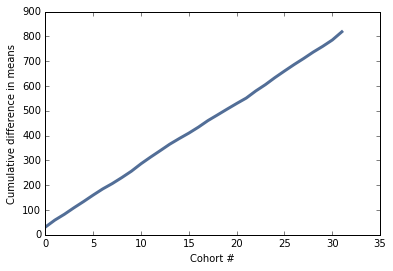

In [22]:
xs, ys = zip(*res)
thinkplot.Plot(xs, ys)
thinkplot.Config(xlabel='Cohort #',
                ylabel='Cumulative difference in means',
                legend=False)

The results looks pretty much the same using J-S divergence.

In [23]:
res = []
cumulative = 0
for i in range(len(cohorts)-1):
    td = cohorts[i].total_divergence(cohorts[i+1], JSDivergence)
    cumulative += td
    print(i, td, cumulative)
    res.append((i, cumulative))

0 6.7725572289 6.7725572289
1 5.62917236405 12.4017295929
2 5.0624907141 17.464220307
3 4.17000968182 21.6342299889
4 4.28812434098 25.9223543299
5 4.82791915546 30.7502734853
6 4.68718559848 35.4374590838
7 4.68468177153 40.1221408553
8 5.05290361605 45.1750444714
9 4.73898052765 49.914024999
10 4.70690791746 54.6209329165
11 4.50240017279 59.1233330893
12 4.27566340317 63.3989964924
13 4.25538202128 67.6543785137
14 3.81795459454 71.4723331083
15 3.87937009897 75.3517032072
16 4.04261284213 79.3943160494
17 4.08350528576 83.4778213351
18 4.48996769966 87.9677890348
19 3.91403460156 91.8818236363
20 3.84677999195 95.7286036283
21 3.80839549117 99.5369991195
22 4.51411169618 104.051110816
23 4.08910255992 108.140213376
24 4.4797335534 112.619946929
25 4.89923921364 117.519186143
26 4.31338353073 121.832569673
27 4.2918089177 126.124378591
28 4.12560127765 130.249979869
29 3.9072987636 134.157278632
30 4.5453620366 138.702640669
31 8.30423913322 147.006879802


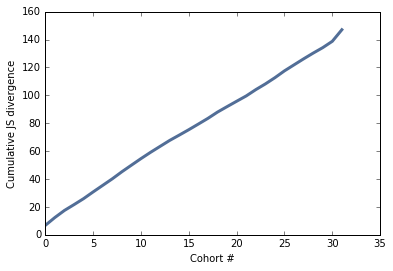

In [24]:
xs, ys = zip(*res)
thinkplot.Plot(xs, ys)
thinkplot.Config(xlabel='Cohort #',
                ylabel='Cumulative JS divergence',
                legend=False)

Conclusion: Using this set of questions from the GSS, and two measures of divergence, it seems that the total divergence between successive cohorts is nearly constant over time.

If a "generation" is supposed to be a sequence of cohorts with relatively small differences between them, punctuated by periods of larger differences, this study suggests that generations do not exist.